In [1]:
body = r"e:\unet_new\train_101_a_1.nii.gz"
seg = r"E:\unet_new\train_101_a_1_total_seg"

In [2]:
nifiti = r"E:\unet_new\Nifiti"
mask = r"E:\unet_new\mask"

In [3]:
#pc.process_patient("101_a_1", nifiti, r"E:\unet_new\output", 0)

In [4]:
full_ct = r"e:\unet_new\Nifiti\CT_no_bed\101_a_1.nii.gz"
bones = r"e:\unet_new\output\101_a_1\101_a_1_bones_real.nii.gz"
spine = r"e:\unet_new\output\101_a_1\101_a_1_spine_real.nii.gz"
rib = r"e:\unet_new\output\101_a_1\101_a_1_rib_real.nii.gz"
soft_tissue = r"e:\unet_new\output\101_a_1\101_a_1_soft_tissue.nii.gz"

In [5]:
import sys
sys.path.append(r"C:\Users\10648\OneDrive\0 Research\CT_Rate_Process")

In [6]:
import PP_DRR_SDD_check as pdrr
# Correct imports for DRR functions from diffdrr
from diffdrr.drr import DRR
from diffdrr.data import read
from diffdrr.pose import convert
import torch
from diffdrr.visualization import plot_drr
import matplotlib.pyplot as plt
import torchio as tio
import numpy as np
import nibabel as nib
import torch.nn.functional as F

In [7]:


def resize_tensor(img_tensor, scale=2):
    """
    Resize a 2D or 4D tensor by scaling its height and width.
    :param img_tensor: Input tensor with shape (H, W), (1, H, W), or (1, 1, H, W).
    :param scale: Scale factor for resizing (default is 2 for doubling size).
    :return: Resized tensor with the same number of dimensions as the input.
    """
    # Ensure img_tensor is at least 4D for resizing
    if img_tensor.dim() == 2:
        img_tensor = img_tensor.unsqueeze(0).unsqueeze(0)  # Convert (H, W) to (1, 1, H, W)
    elif img_tensor.dim() == 3:
        img_tensor = img_tensor.unsqueeze(0)  # Convert (1, H, W) to (1, 1, H, W)

    # Resize the tensor
    resized_tensor = F.interpolate(img_tensor, scale_factor=scale, mode='bilinear', align_corners=False)

    # Return the resized tensor, keeping the same dimensionality as the input
    if img_tensor.dim() == 4:
        return resized_tensor  # If input was (1, 1, H, W), return as is
    elif img_tensor.dim() == 3:
        return resized_tensor.squeeze(0)  # If input was (1, H, W), squeeze batch dim
    elif img_tensor.dim() == 2:
        return resized_tensor.squeeze(0).squeeze(0)  # If input was (H, W), squeeze both batch and channel dims

In [8]:
import matplotlib.pyplot as plt
import torch

def plot_drr_large(img: torch.Tensor, figsize=(12, 12), title=None, ticks=False, cmap="gray"):
    """
    Plot a DRR image with a customizable figure size.
    
    :param img: Input tensor (2D or with batch/channel dimensions).
    :param figsize: Tuple specifying the size of the figure (width, height).
    :param title: Title of the plot.
    :param ticks: Whether to show axis ticks (default: False).
    :param cmap: Colormap for the plot (default: "gray").
    """
    # Handle tensor dimensions
    if img.dim() == 4:  # (n_imgs, channels, height, width)
        img = img[0, 0]  # Select the first image and first channel
    elif img.dim() == 3:  # (channels, height, width)
        img = img[0]  # Select the first channel
    
    # Convert to 2D NumPy array
    img_2d = img.squeeze().detach().cpu().numpy()

    # Create a figure with the specified size
    plt.figure(figsize=figsize)
    plt.imshow(img_2d, cmap=cmap)
    if title:
        plt.title(title)
    if not ticks:
        plt.axis("off")  # Hide axes
    plt.show()


In [9]:
rotate = [[3.0, 0.0, 0.0]]
translate = [[0.0, 1120 - 167.2, 0.0]]
bone_multi = 2.0
orientation = "AP"
default_sdd = 1120
num_workers = 10  # Number of workers for parallel processing
meta_csv = r"c:\Research\CT-RATE\train_metadata.csv"
device = "cpu"


In [10]:

volume = full_ct
header = pdrr.read_nii_data(volume)

subject = read(volume, orientation=orientation, bone_attenuation_multiplier=bone_multi)
drr = DRR(subject, sdd=1120, height=header['dim'][1], delx=(header.get_zooms())[0], renderer="trilinear").to(device)

rotations = torch.tensor(rotate, device=device)
translations = torch.tensor(translate, device=device)
'''
img = drr(rotations, translations, parameterization="euler_angles", convention="ZXY")
plot_drr(img, ticks=True)
plt.show()
'''

'\nimg = drr(rotations, translations, parameterization="euler_angles", convention="ZXY")\nplot_drr(img, ticks=True)\nplt.show()\n'

In [11]:
def process_inputs(bones_path, spine_path, rib_path, soft_tissue_path):
    """
    Step 1: Reads NIfTI files, processes the data, and returns the combined ScalarImage,
    affine, and header information.
    """
    # Load NIfTI files
    bones_nii = nib.load(bones_path)
    spine_nii = nib.load(spine_path)
    rib_nii = nib.load(rib_path)
    soft_tissue_nii = nib.load(soft_tissue_path)
    
    # Extract data arrays
    bones_array = bones_nii.get_fdata()
    spine_array = spine_nii.get_fdata()
    rib_array = rib_nii.get_fdata()
    soft_tissue_array = soft_tissue_nii.get_fdata()

    # Extract affine and header from soft_tissue
    affine = soft_tissue_nii.affine
    header = soft_tissue_nii.header

    # Desired voxel size (from the original full CT)
    voxel_size = soft_tissue_nii.header.get_zooms()  # (x_size, y_size, z_size)

    # Modify the affine matrix
    affine[:3, :3] = np.diag(voxel_size)  # Update scaling factors in affine
    
    
    
    return bones_array, spine_array, rib_array, soft_tissue_array, affine, header

In [12]:
def combine_img(bones_array, spine_array, rib_array, soft_tissue_array, affine):
    """
    Step 2: Combine the masks and return the combined image.
    """
    # Create a copy of the soft tissue array as the base
    combined_array = np.copy(soft_tissue_array)

    # Replace values in the base array with those from other parts
    # This assumes non-zero values in parts arrays indicate regions to replace
    combined_array[bones_array >= -990] = bones_array[bones_array >= -990]
    combined_array[spine_array >= -990] = spine_array[spine_array >= -990]
    combined_array[rib_array >= -990] = rib_array[rib_array >= -990]

    # Add channel dimension to make the tensor 4D
    combined_array = np.expand_dims(combined_array, axis=0)   # Shape: (1, H, W, D)

    # Create ScalarImage
    combined_image = tio.ScalarImage(tensor=combined_array, affine=affine)
    
    return combined_image

In [13]:
def generate_drr(volume, header, orientation, bone_multi, rotate, translate, device, sdd=1120):
    """
    Step 3: Takes the combined volume, header, and other parameters to generate a DRR image.
    """
    # Create subject using the combined volume and orientation
    subject = read(volume, orientation=orientation, bone_attenuation_multiplier=bone_multi)
    
    # Initialize DRR object
    drr = DRR(
        subject,
        sdd=sdd,
        height=header['dim'][1],  # Image height
        delx=(header.get_zooms())[0],  # Pixel spacing
        renderer="trilinear"
    ).to(device)
    
    # Set rotations and translations
    rotations = torch.tensor(rotate, device=device)
    translations = torch.tensor(translate, device=device)
    
    # Generate DRR image
    img = drr(rotations, translations, parameterization="euler_angles", convention="ZXY")
    
    return img

In [14]:
bones_array, spine_array, rib_array, soft_tissue_array, affine, header = process_inputs(bones, spine, rib, soft_tissue)

In [15]:
import torch
'''
# Assuming the original arrays are numpy arrays
bones_array_cp = torch.from_numpy(bones_array).clone().to('cuda')
spine_array_cp = torch.from_numpy(spine_array).clone().to('cuda')
rib_array_cp = torch.from_numpy(rib_array).clone().to('cuda')
soft_tissue_array_cp = torch.from_numpy(soft_tissue_array).clone().to('cuda')
'''

"\n# Assuming the original arrays are numpy arrays\nbones_array_cp = torch.from_numpy(bones_array).clone().to('cuda')\nspine_array_cp = torch.from_numpy(spine_array).clone().to('cuda')\nrib_array_cp = torch.from_numpy(rib_array).clone().to('cuda')\nsoft_tissue_array_cp = torch.from_numpy(soft_tissue_array).clone().to('cuda')\n"

In [16]:
bones_array_cp = bones_array.copy()
spine_array_cp = spine_array.copy()
rib_array_cp = rib_array.copy()
soft_tissue_array_cp = soft_tissue_array.copy()

In [17]:
import os
def extract_patient_data(ct_no_bed_folder, sep_ct_folder, patient_name):
    """
    Extracts file paths for CT and related components and processes the data.

    Parameters:
        ct_no_bed_folder (str): Path to the folder containing the CT_no_bed file.
        sep_ct_folder (str): Path to the folder containing the sep_ct files (bones, spine, rib, soft_tissue).
        patient_name (str): Name of the patient (e.g., '101_a_1').

    Returns:
        tuple: full_ct path and the outputs of process_inputs function.

    Raises:
        FileNotFoundError: If any required file is missing.
    """
    # Construct file paths
    full_ct = os.path.join(ct_no_bed_folder, f"{patient_name}.nii.gz")
    bones = os.path.join(sep_ct_folder, patient_name, f"{patient_name}_bones_real.nii.gz")
    spine = os.path.join(sep_ct_folder, patient_name, f"{patient_name}_spine_real.nii.gz")
    rib = os.path.join(sep_ct_folder, patient_name, f"{patient_name}_rib_real.nii.gz")
    soft_tissue = os.path.join(sep_ct_folder, patient_name, f"{patient_name}_soft_tissue.nii.gz")

    # Check if files exist
    if not os.path.exists(full_ct):
        raise FileNotFoundError(f"CT file not found: {full_ct}")
    if not os.path.exists(bones):
        raise FileNotFoundError(f"Bones file not found: {bones}")
    if not os.path.exists(spine):
        raise FileNotFoundError(f"Spine file not found: {spine}")
    if not os.path.exists(rib):
        raise FileNotFoundError(f"Rib file not found: {rib}")
    if not os.path.exists(soft_tissue):
        raise FileNotFoundError(f"Soft tissue file not found: {soft_tissue}")

    # Process inputs
    bones_array, spine_array, rib_array, soft_tissue_array, affine, header = process_inputs(
        bones, spine, rib, soft_tissue
    )

    # Return the full CT path and processed data
    return full_ct, bones_array, spine_array, rib_array, soft_tissue_array, affine, header

In [47]:
from scipy.ndimage import binary_dilation, binary_erosion
import numpy as np

def find_surface(array):
    # Create a binary mask of the structure
    binary_mask = array >= -100  # Assume non-zero values are part of the structure

    # Dilate and erode to find the surface
    outer_surface = binary_dilation(binary_mask) & ~binary_mask
    inner_surface = binary_mask & ~binary_erosion(binary_mask)

    # Combine to get the surface mask
    surface_mask = outer_surface | inner_surface

    return surface_mask, outer_surface, inner_surface

def find_inner_surface(binary_mask, inner_percentage=3):
    # Estimate the number of layers for the given percentage
    total_thickness = max(binary_mask.shape)
    inner_layers = int(total_thickness * inner_percentage / 100)

    # Erode to find the inner region
    inner_surface = binary_mask & ~binary_erosion(binary_mask, iterations=inner_layers)

    return inner_surface


def adjust_surface_intensity(array, surface_mask, inner_surface, adjustment_factor=1.1):
    # Initialize adjusted array
    adjusted_array = array.copy()

    # Ensure the surface masks match the array's shape
    if surface_mask.shape != array.shape:
        raise ValueError("Surface mask shape does not match array shape.")
    if inner_surface.shape != array.shape:
        raise ValueError("Inner surface shape does not match array shape.")

    # Apply enhancement to the outer surface
    adjusted_array[surface_mask] *= adjustment_factor

    # Smooth transition for the inner surface
    inner_distance = np.zeros_like(array, dtype=np.float32)
    inner_distance[inner_surface] = 1.0  # Mark the inner surface
    max_distance = np.amax(inner_distance)

    if max_distance > 0:
        # Create a linear transition from 1 to the adjustment factor
        transition_factor = np.linspace(1, adjustment_factor, int(max_distance))
        for i, factor in enumerate(transition_factor):
            layer_mask = inner_distance == i
            adjusted_array[layer_mask] *= factor

    return adjusted_array

def enhance_surface(array, adjustment_factor=1.1, inner_percentage=3):
    # Step 1: Find surface voxels
    surface_mask, outer_surface, inner_surface = find_surface(array)

    # Step 2: Find the inner surface region
    binary_mask = array > 0
    inner_surface = find_inner_surface(binary_mask, inner_percentage=inner_percentage)

    # Step 3: Apply intensity adjustment with transition
    enhanced_array = adjust_surface_intensity(array, surface_mask, inner_surface, adjustment_factor)

    return enhanced_array

def adjust_vertical_transition(volume, vertical_point_lower, adjustment_factor, top_down=True, speed=1.0):
    """
    Adjust the values in a 3D numpy array by scaling the lower part (below a vertical point)
    with a smooth transition along the vertical axis (z-axis). Only values >= -990 are processed.

    Parameters:
        volume (np.ndarray): The 3D array to be adjusted.
        vertical_point_lower (float): A relative vertical position (0 to 1) to start the adjustment.
                                    This means we adjust the lower % of the volume.
        adjustment_factor (float): The scaling factor for the adjustment.
        top_down (bool): If True, apply a top-down fade; if False, apply a bottom-up fade.
        speed (float): A factor controlling how quickly the fade occurs. Higher values mean faster fading.

    Returns:
        np.ndarray: The adjusted 3D array.
    """
    # Validate inputs
    if not (0 <= vertical_point_lower <= 1):
        raise ValueError("vertical_point_lower must be between 0 and 1.")
    if adjustment_factor < 0:
        raise ValueError("adjustment_factor must be non-negative.")
    if speed <= 0:
        raise ValueError("speed must be greater than 0.")

    # Determine the slice index corresponding to the vertical point
    z_size = volume.shape[2]  # Corrected for z-axis being the third dimension
    vertical_index = int(vertical_point_lower * z_size)

    # Create a smooth transition mask for the z-axis
    transition = np.ones(z_size)
    if top_down:
        transition[:vertical_index] = np.linspace(adjustment_factor, 1, int(vertical_index * speed))[:vertical_index]  # Top-down fade
    else:
        transition[vertical_index:] = np.linspace(1, adjustment_factor, int((z_size - vertical_index) * speed))[:z_size - vertical_index]  # Bottom-up fade

    # Apply the transition mask along the z-axis only to values >= -990
    adjusted_volume = volume.copy()
    for z in range(z_size):
        mask = adjusted_volume[:, :, z] >= -990  # Filter out background
        adjusted_volume[:, :, z][mask] *= transition[z]  # Adjust along the third dimension

    return adjusted_volume

In [20]:
ct_no_bed_folder = r"D:\drr_real_study\single_CT"
sep_ct_folder = r"D:\drr_real_study\Sep_cts"
patient_name = "101_a_1"
full_ct, bones_array_cp, spine_array_cp, rib_array_cp, soft_tissue_array_cp, affine, header = extract_patient_data(ct_no_bed_folder, sep_ct_folder, patient_name)

In [21]:
bones_array_new = enhance_surface(bones_array_cp, adjustment_factor=1.1, inner_percentage=3)

In [22]:
rib_array_new = enhance_surface(rib_array_cp, adjustment_factor=2.5, inner_percentage=70)

In [23]:
spine_array_adj = enhance_surface(spine_array_cp, adjustment_factor=0.7, inner_percentage=100)


In [48]:
spine_array_new = adjust_vertical_transition(spine_array_adj, vertical_point_lower=0.7, adjustment_factor=0.2, top_down=1, speed = 1.5)

In [32]:
# File paths
full_ct = r"e:\unet_new\Nifiti\CT_no_bed\101_a_1.nii.gz"
# Load NIfTI files
full_ct_nii = nib.load(full_ct)


In [50]:
# Path to save the combined result
output_path = r"E:\unet_new\output\101_a_1\new_spine.nii.gz"

# Create a NIfTI image using the combined array, affine, and header
combined_nii = nib.Nifti1Image(spine_array_new, affine=full_ct_nii.affine, header=full_ct_nii.header)

# Save the NIfTI image
#nib.save(combined_nii, output_path)

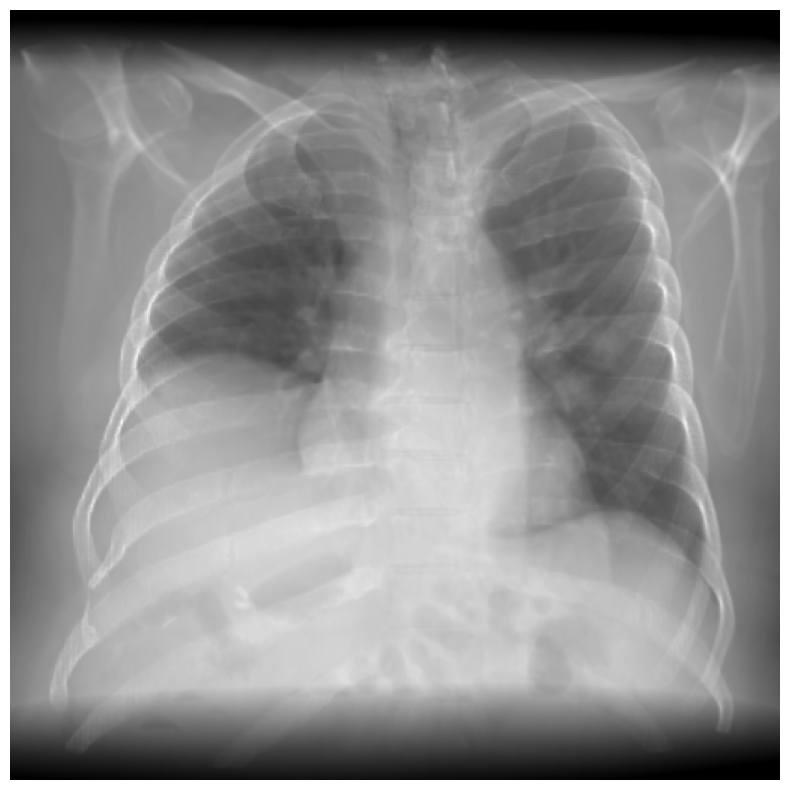

In [49]:
combined_img = combine_img(bones_array_new, spine_array_new, rib_array_new, soft_tissue_array_cp, affine)

img = generate_drr(combined_img, header, orientation, bone_multi, [[3.0, 0.0, 0.0]], translate = [[0.0, 1220 - 167.2, 0.0]], device = device, sdd=1220)
plot_drr_large(img, figsize=(10, 10), title= None, ticks=False)
plt.show()

In [134]:
a = r"d:\drr_real_study\single_CT\t_87_a_1.nii.gz"

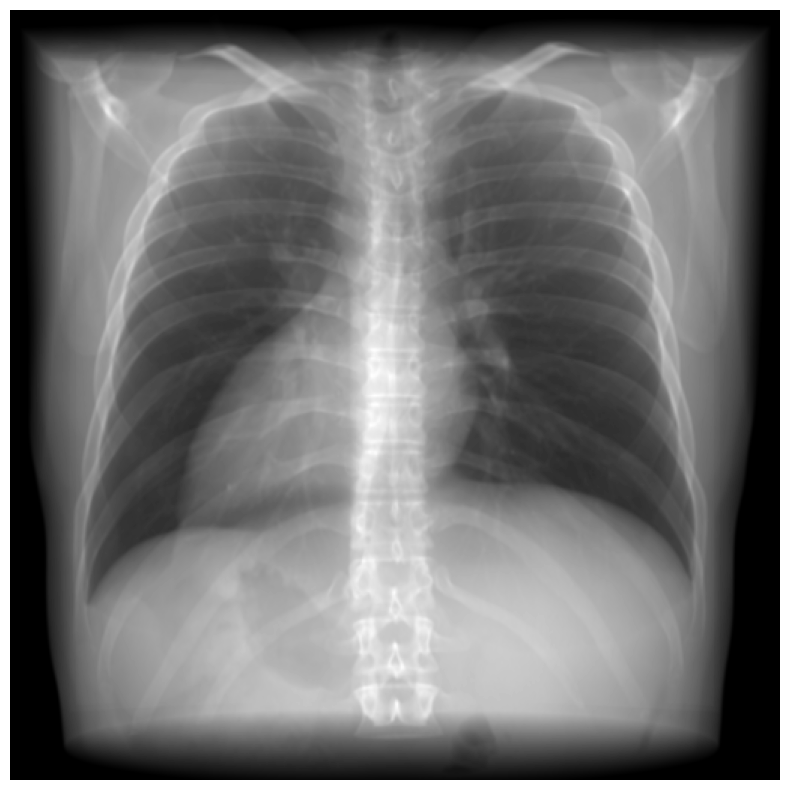

In [135]:
img = generate_drr(a, header, orientation, bone_multi, [[0.0, 0.0, 0.0]], translate = [[0.0, 1220 - 167.2, 0.0]], device = device, sdd=1220)
plot_drr_large(img, figsize=(10, 10), title= None, ticks=False)
plt.show()

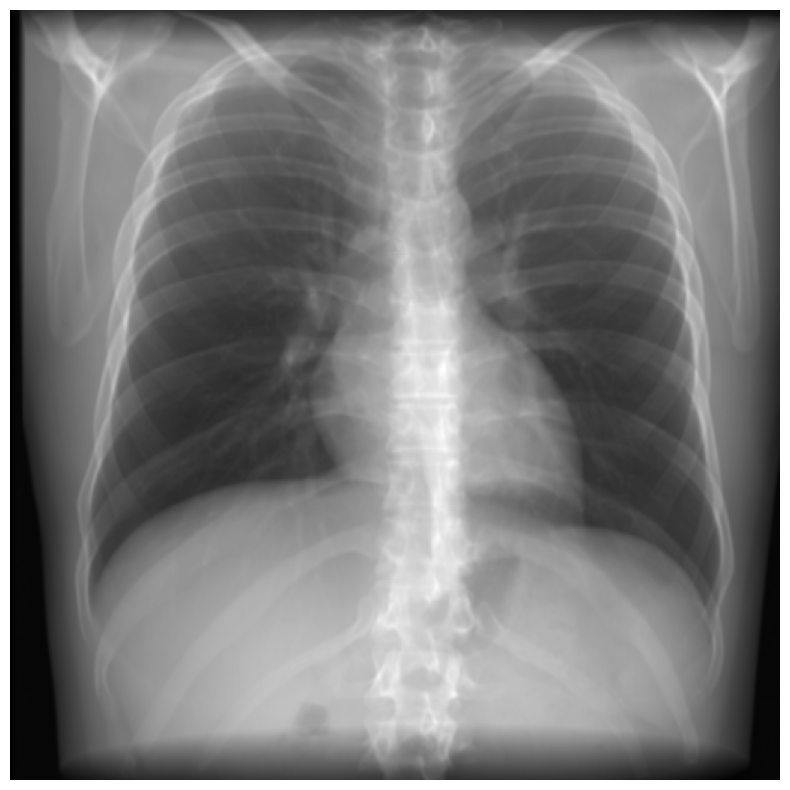

In [136]:
img = generate_drr(a, header, orientation, bone_multi, [[3.0, 0.0, 0.0]], translate = [[0.0, 1220 - 167.2, 0.0]], device = device, sdd=1220)
plot_drr_large(img, figsize=(10, 10), title= None, ticks=False)
plt.show()

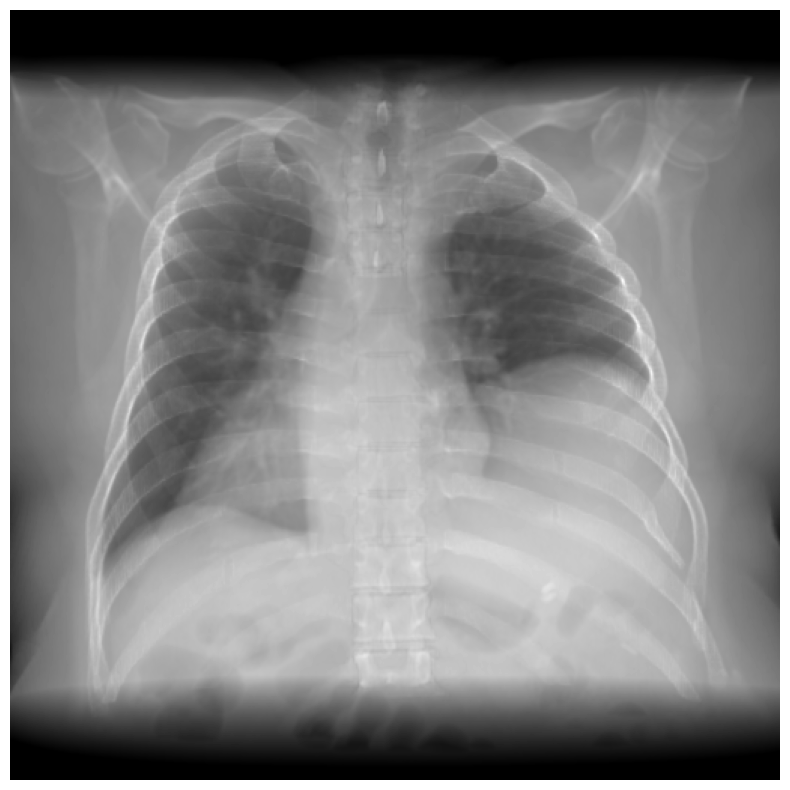

In [133]:
img = generate_drr(combined_img, header, orientation, bone_multi, [[0.0, 0.0, 0.0]], translate = [[0.0, 1220 - 167.2, 0.0]], device = device, sdd=1220)
plot_drr_large(img, figsize=(10, 10), title= None, ticks=False)
plt.show()

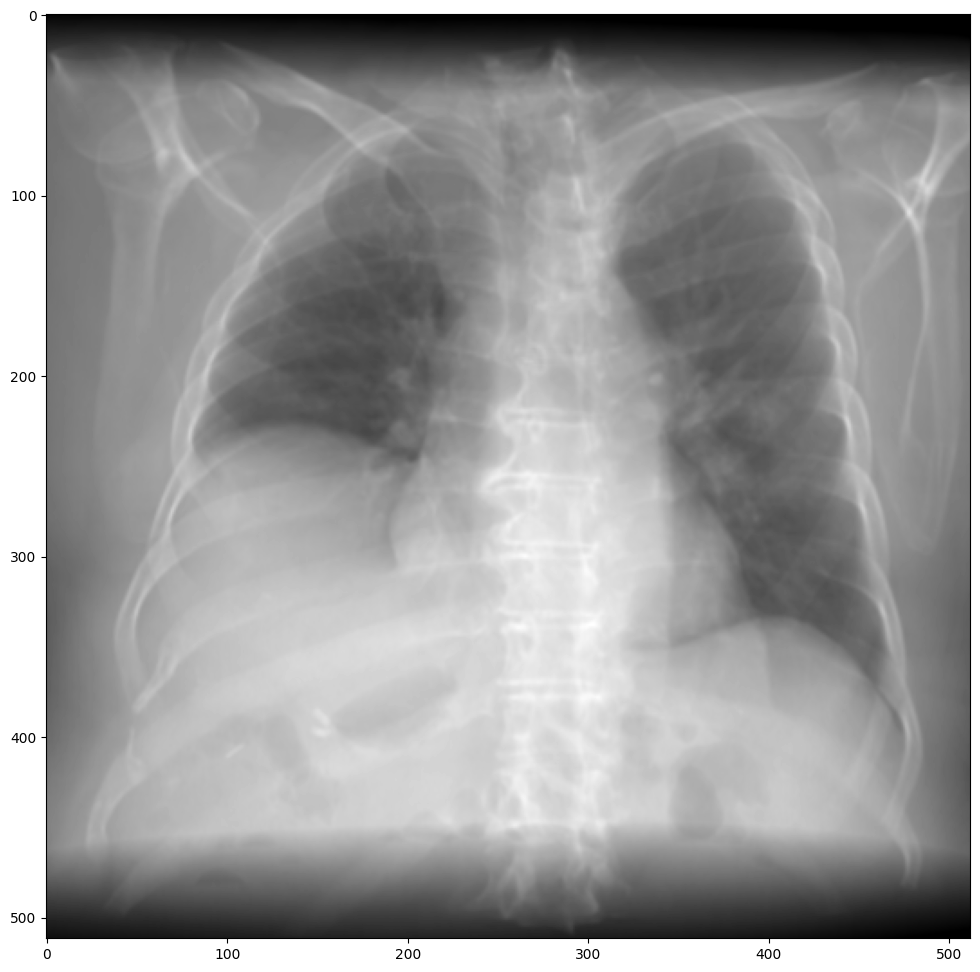

In [ ]:
img2 = generate_drr(full_ct, header, orientation, bone_multi, rotate, translate, device)
plot_drr_large(img, figsize=(10, 10), title="DRR Image", ticks=False)
plt.show()

In [102]:
# Path to save the combined result
output_path = r"E:\unet_new\output\101_a_1\new_spine.nii.gz"

# Create a NIfTI image using the combined array, affine, and header
combined_nii = nib.Nifti1Image(spine_array_new, affine=full_ct_nii.affine, header=full_ct_nii.header)

# Save the NIfTI image
nib.save(combined_nii, output_path)

In [14]:
import nibabel as nib
import numpy as np

# File paths
full_ct = r"e:\unet_new\Nifiti\CT_no_bed\101_a_1.nii.gz"
bones = r"e:\unet_new\output\101_a_1\101_a_1_bones_real.nii.gz"
spine = r"e:\unet_new\output\101_a_1\101_a_1_spine_real.nii.gz"
rib = r"e:\unet_new\output\101_a_1\101_a_1_rib_real.nii.gz"
soft_tissue = r"e:\unet_new\output\101_a_1\101_a_1_soft_tissue.nii.gz"

# Load NIfTI files
full_ct_nii = nib.load(full_ct)
bones_nii = nib.load(bones)
spine_nii = nib.load(spine)
rib_nii = nib.load(rib)
soft_tissue_nii = nib.load(soft_tissue)

# Extract data arrays
full_ct_array = full_ct_nii.get_fdata()
bones_array = bones_nii.get_fdata()
spine_array = spine_nii.get_fdata()
rib_array = rib_nii.get_fdata()
soft_tissue_array = soft_tissue_nii.get_fdata()

# Combine the arrays
combined_array = bones_array + spine_array + rib_array + soft_tissue_array

# Check if shapes are the same
if combined_array.shape == full_ct_array.shape:
    print("The combined array has the same shape as the full CT image.")
else:
    print("The shapes are different.")
    print(f"Combined array shape: {combined_array.shape}")
    print(f"Full CT image shape: {full_ct_array.shape}")


The combined array has the same shape as the full CT image.


In [31]:
# Check if shapes are the same
if combined_array.shape == full_ct_array.shape:
    # Check if all elements are identical
    if np.array_equal(combined_array, full_ct_array):
        print("The combined array is identical to the full CT image.")
    else:
        print("The combined array and the full CT image have the same shape but different content.")
else:
    print("The shapes are different.")
    print(f"Combined array shape: {combined_array.shape}")
    print(f"Full CT image shape: {full_ct_array.shape}")


The combined array and the full CT image have the same shape but different content.


In [60]:
# Path to save the combined result
output_path = r"E:\unet_new\output\101_a_1\new_bone.nii.gz"

# Create a NIfTI image using the combined array, affine, and header
combined_nii = nib.Nifti1Image(bones_array_new, affine=full_ct_nii.affine, header=full_ct_nii.header)

# Save the NIfTI image
nib.save(combined_nii, output_path)

In [21]:
# Create a copy of the soft tissue array as the base
combined_array = np.copy(soft_tissue_array)

# Replace values in the base array with those from other parts
# This assumes non-zero values in parts arrays indicate regions to replace
combined_array[bones_array >= -990] = bones_array[bones_array >= -990]
combined_array[spine_array >= -990] = spine_array[spine_array >= -990]
combined_array[rib_array >= -990] = rib_array[rib_array >= -990]


In [22]:
# Check if shapes are the same
if combined_array.shape == full_ct_array.shape:
    # Check if all elements are identical
    if np.array_equal(combined_array, full_ct_array):
        print("The combined array is identical to the full CT image.")
    else:
        print("The combined array and the full CT image have the same shape but different content.")
else:
    print("The shapes are different.")
    print(f"Combined array shape: {combined_array.shape}")
    print(f"Full CT image shape: {full_ct_array.shape}")

The combined array and the full CT image have the same shape but different content.


In [26]:
# Calculate the absolute difference
absolute_difference = np.abs(combined_array - full_ct_array)

# Calculate the percentage difference
percentage_difference = (absolute_difference / np.abs(full_ct_array)) * 100

# Handle cases where `full_ct_array` values are zero to avoid division by zero
percentage_difference[np.abs(full_ct_array) < 1e-6] = 0  # Set to 0% difference for near-zero values

# Calculate the overall mean percentage difference
mean_percentage_difference = np.mean(percentage_difference)

# Output the result
print(f"The mean percentage difference between the combined array and the full CT image is: {mean_percentage_difference:.2f}%")


The mean percentage difference between the combined array and the full CT image is: 0.14%


In [53]:
import torch

# Example tensors (replace with img and img2)
# Ensure they have the same shape
if img.shape != img2.shape:
    raise ValueError("Tensors must have the same shape to calculate the difference.")

# Calculate the absolute difference
difference = torch.abs(img - img2)

# Calculate the mean absolute difference
mean_diff = torch.mean(difference)

# Output results
print(f"Mean absolute difference: {mean_diff.item():.6f}")


Mean absolute difference: 0.000011


cxr_classify

In [ ]:
import os
import cv2
import numpy as np
from sklearn.cluster import KMeans
import shutil
from tqdm import tqdm


def delete_folder(folder_path):
    """Delete the specified folder and its contents."""
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
        print(f"Folder '{folder_path}' and its contents have been deleted.")
    else:
        print(f"Folder '{folder_path}' does not exist.")

def load_images(folder_path, file_extension=".png"):
    """Load all images with the specified extension from a folder."""
    images = []
    file_names = []
    for file in os.listdir(folder_path):
        if file.endswith(file_extension):
            img_path = os.path.join(folder_path, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
            if img is not None:
                images.append((file, img))
    return images

def histogram_equalization(image):
    """Apply histogram equalization to enhance contrast."""
    return cv2.equalizeHist(image)

def extract_histogram_features(image):
    """Extract normalized histogram features from the image."""
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])  # Histogram for 256 bins
    hist = cv2.normalize(hist, hist).flatten()  # Normalize and flatten
    return hist

def cluster_images(features, n_clusters=5):
    """Cluster images into n_clusters using k-means."""
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(features)
    return labels

def organize_images_by_category(images, labels, output_folder):
    """Organize images into subfolders based on their cluster labels."""
    for label in np.unique(labels):
        category_folder = os.path.join(output_folder, f"cat_{label + 1}")
        os.makedirs(category_folder, exist_ok=True)
    
    for (file_name, _), label in zip(images, labels):
        source_path = os.path.join(input_folder, file_name)
        destination_path = os.path.join(output_folder, f"cat_{label + 1}", file_name)
        shutil.copy(source_path, destination_path)

def main(input_folder, output_folder, n_clusters=5):
    delete_folder(output_folder)

    # Step 1: Load images
    print("Loading images...")
    images = load_images(input_folder)
    if not images:
        print(f"No images found in {input_folder}. Exiting...")
        return

    # Step 2: Preprocess images and extract features
    print("Processing images and extracting features...")
    features = []
    for file_name, img in tqdm(images):
        equalized_img = histogram_equalization(img)
        hist_features = extract_histogram_features(equalized_img)
        features.append(hist_features)
    
    features = np.array(features)

    # Step 3: Cluster images
    print("Clustering images into categories...")
    labels = cluster_images(features, n_clusters)

    # Step 4: Organize images into subfolders
    print("Organizing images into subfolders...")
    organize_images_by_category(images, labels, output_folder)

    print("Classification complete. Images organized into subfolders.")

if __name__ == "__main__":
    # Define input and output paths
    input_folder = r"C:\Users\10648\OneDrive\storage\healthy_sample"
    output_folder = r"C:\Users\10648\OneDrive\storage\classified_samples"
    
    # Run the classification process
    main(input_folder, output_folder)


Loading images...
Processing images and extracting features...


100%|██████████| 300/300 [00:00<00:00, 352.95it/s]


Clustering images into categories...
Organizing images into subfolders...
Classification complete. Images organized into subfolders.


In [ ]:
def binary_dilation_torch(binary_mask, kernel_size=3):
    """
    Perform binary dilation on the GPU using PyTorch.
    :param binary_mask: Input 3D binary mask (torch.Tensor, GPU-compatible).
    :param kernel_size: Size of the dilation kernel (default is 3).
    :return: Dilated binary mask (torch.Tensor).
    """
    padding = kernel_size // 2
    # Add batch and channel dimensions if necessary
    if binary_mask.dim() == 3:
        binary_mask = binary_mask.unsqueeze(0).unsqueeze(0)  # (1, 1, D, H, W)
    elif binary_mask.dim() == 2:
        binary_mask = binary_mask.unsqueeze(0).unsqueeze(0)  # (1, 1, H, W)
    
    dilated = F.max_pool3d(binary_mask.float(), kernel_size=kernel_size, stride=1, padding=padding)
    return dilated.squeeze(0).squeeze(0).bool()  # Remove batch and channel dimensions


def binary_erosion_torch(binary_mask, kernel_size=3):
    """
    Perform binary erosion on the GPU using PyTorch.
    :param binary_mask: Input 3D binary mask (torch.Tensor, GPU-compatible).
    :param kernel_size: Size of the erosion kernel (default is 3).
    :return: Eroded binary mask (torch.Tensor).
    """
    padding = kernel_size // 2
    # Add batch and channel dimensions if necessary
    if binary_mask.dim() == 3:
        binary_mask = binary_mask.unsqueeze(0).unsqueeze(0)  # (1, 1, D, H, W)
    elif binary_mask.dim() == 2:
        binary_mask = binary_mask.unsqueeze(0).unsqueeze(0)  # (1, 1, H, W)
    
    eroded = -F.max_pool3d(-binary_mask.float(), kernel_size=kernel_size, stride=1, padding=padding)
    return eroded.squeeze(0).squeeze(0).bool()  # Remove batch and channel dimensions


def find_surface_torch(array, kernel_size=3):
    """
    Find the surface of a binary mask using GPU-based dilation and erosion.
    :param array: Input binary mask (torch.Tensor, GPU-compatible).
    :param kernel_size: Size of the kernel for dilation/erosion (default is 3).
    :return: surface_mask, outer_surface, inner_surface as torch.Tensors.
    """
    binary_mask = array >= -100  # Binary threshold

    # Perform dilation and erosion
    outer_surface = binary_dilation_torch(binary_mask, kernel_size=kernel_size) & ~binary_mask
    inner_surface = binary_mask & ~binary_erosion_torch(binary_mask, kernel_size=kernel_size)

    # Combine outer and inner surfaces
    surface_mask = outer_surface | inner_surface

    return surface_mask, outer_surface, inner_surface


def find_inner_surface_torch(binary_mask, inner_percentage=3):
    """
    Find the inner surface of a binary mask using GPU-based erosion.
    :param binary_mask: Input binary mask (torch.Tensor, GPU-compatible).
    :param inner_percentage: Percentage of total thickness for erosion.
    :return: Inner surface as a torch.Tensor.
    """
    # Estimate the number of layers for erosion
    total_thickness = max(binary_mask.shape)
    inner_layers = int(total_thickness * inner_percentage / 100)

    # Perform erosion to find the inner region
    inner_surface = binary_mask & ~binary_erosion_torch(binary_mask, kernel_size=inner_layers * 2 + 1)

    return inner_surface


def adjust_surface_intensity_torch(array, surface_mask, inner_surface, adjustment_factor=1.1):
    """
    Adjust the intensity of the surface and inner surface regions in a 3D tensor.
    :param array: Input tensor (PyTorch, GPU-compatible).
    :param surface_mask: Boolean tensor marking the surface regions.
    :param inner_surface: Boolean tensor marking the inner surface regions.
    :param adjustment_factor: Factor to enhance the intensity of the surface.
    :return: Adjusted array (same shape and device as input array).
    """
    # Ensure the masks are the same shape as the input array
    if surface_mask.shape != array.shape:
        raise ValueError("Surface mask shape does not match array shape.")
    if inner_surface.shape != array.shape:
        raise ValueError("Inner surface shape does not match array shape.")

    # Clone the input array to create an independent adjusted version
    adjusted_array = array.clone()

    # Apply enhancement to the outer surface
    adjusted_array[surface_mask] *= adjustment_factor

    # Smooth transition for the inner surface
    inner_distance = torch.zeros_like(array, dtype=torch.float32)
    inner_distance[inner_surface] = 1.0  # Mark the inner surface with 1.0

    max_distance = inner_distance.max().item()

    if max_distance > 0:
        # Create a linear transition from 1 to the adjustment factor
        transition_factors = torch.linspace(1, adjustment_factor, steps=int(max_distance), device=array.device)
        for i, factor in enumerate(transition_factors):
            layer_mask = (inner_distance == i)
            adjusted_array[layer_mask] *= factor

    return adjusted_array